In [1]:
import pandas as pd
import numpy as np
import os,sys
import json
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            result.append(lemmatize_stemming(token))
    return result

train_df = pd.read_csv('/Users/Administrator/Downloads/FakeNewsWSDM/train.csv')
test_df = pd.read_csv('/Users/Administrator/Downloads/FakeNewsWSDM/test.csv') 

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Administrator/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [47]:
len(train_df)

545781

In [ ]:
j=0
for i in range(len(train_df)):
    if train_df['label'][i] == 'disagreed':
        j = j+1

In [2]:
temp_df = train_df.ix[(train_df['label'] == 'disagreed'),['id', 'tid1','tid2', 'title1_zh', 'title2_zh','title1_en','title2_en','label']]

/Users/Administrator/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [3]:
for i in range(4):
    temp_df = temp_df.append(temp_df,ignore_index=True)

In [6]:
temp_df_agreed = train_df.ix[(train_df['label'] == 'agreed'),['id', 'tid1','tid2', 'title1_zh', 'title2_zh','title1_en','title2_en','label']]

In [9]:
train_df = train_df.append(temp_df, ignore_index=True)
train_df = train_df.append(temp_df_agreed, ignore_index=True)

In [13]:
len(train_df)

545781

In [14]:
data_text_t1_en = train_df[['title1_en']] #+ test_df[['title1_en']]
data_text_t1_en['index'] = train_df.index
documents_t1 = data_text_t1_en

data_text_t2_en = train_df[['title2_en']] #+ test_df[['title2_en']]
data_text_t2_en['index'] = train_df.index
documents_t2 = data_text_t2_en

documents_t2.columns = ['title1_en', 'index']

docs = documents_t1.append(documents_t2, ignore_index=True)

processed_docs_merged = docs['title1_en'].map(preprocess)

t1_list = list(processed_docs_merged[:545781])
t2_list = list(processed_docs_merged[545781:])

t1_list_str = ['']*len(t1_list)
t2_list_str = ['']*len(t2_list)
for i in range(len(t1_list)):
    t1_list_str[i] = ' '.join(t1_list[i])
for i in range(len(t2_list)):
    t2_list_str[i] = ' '.join(t2_list[i])


data_text_t1_en_test = test_df[['title1_en']] #+ test_df[['title1_en']]
data_text_t1_en_test['index'] = test_df.index
documents_t1_test = data_text_t1_en_test

data_text_t2_en_test = test_df[['title2_en']] #+ test_df[['title2_en']]
data_text_t2_en_test['index'] = test_df.index
documents_t2_test = data_text_t2_en_test

documents_t2_test.columns = ['title1_en', 'index']

docs_test = data_text_t1_en_test.append(data_text_t2_en_test, ignore_index=True)

processed_docs_merged_test = docs_test['title1_en'].map(preprocess)

t1_list_test = list(processed_docs_merged_test[:80126])
t2_list_test = list(processed_docs_merged_test[80126:])

t1_list_test_str = ['']*len(t1_list_test)
t2_list_test_str = ['']*len(t2_list_test)
for i in range(len(t1_list_test)):
    t1_list_test_str[i] = ' '.join(t1_list_test[i])
for i in range(len(t2_list_test)):
    t2_list_test_str[i] = ' '.join(t2_list_test[i])

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
s = 0
count1 = 0
count2 = 0 
count3 = 0

sim_agreed = [0]*len(train_df)
sim_disagreed = [0]*len(train_df)
sim_unrelated = [0]*len(train_df)

for i in range(len(train_df)):
    if train_df['label'][i]=='agreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        list = ['']*2
        list[0] = t1_list_str[i]
        list[1] = t2_list_str[i]  
        m = vect.fit_transform(list).toarray()
        sim_agreed[count1] = sum(np.multiply(m[0],m[1]))/len(m[0])
        #s = s + sum(np.multiply(m[0],m[1]))/len(m[0])
        count1 = count1+1
        
    elif train_df['label'][i]=='disagreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        list = ['']*2
        list[0] = t1_list_str[i]
        list[1] = t2_list_str[i]  
        m = vect.fit_transform(list).toarray()
        sim_disagreed[count2] = sum(np.multiply(m[0],m[1]))/len(m[0])
        #s = s + sum(np.multiply(m[0],m[1]))/len(m[0])
        count2 = count2+1
        
    elif train_df['label'][i]=='unrelated' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        list = ['']*2
        list[0] = t1_list_str[i]
        list[1] = t2_list_str[i]  
        m = vect.fit_transform(list).toarray()
        sim_unrelated[count3] = sum(np.multiply(m[0],m[1]))/len(m[0])
        #s = s + sum(np.multiply(m[0],m[1]))/len(m[0])
        count3 = count3+1
    
        
sim_agreed = sim_agreed[:count1]
sim_disagreed = sim_disagreed[:count2]
sim_unrelated = sim_unrelated[:count3]

/Users/Administrator/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Administrator/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Administrator/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

In [82]:
count1 = 0

for i in range(len(train_df)):
    if train_df['label'][i]=='agreed' and t1_list_str[i] != '' and t2_list_str[i] != '' and count1<10 :
        print(train_df['title1_en'][i] + '\t')
        print(train_df['title2_en'][i] + '\t')
        print(t1_list_str[i] + '\t')
        print(t2_list_str[i] + '\t')
        print(sim_agreed[count1])
        count1 = count1+1

"How to discriminate oil from gutter oil by means of garlic.	
It took 30 years of cooking oil to know that one piece of garlic is easy to spot.	
discrimin gutter mean garlic	
take year cook know piec garlic easi spot	
0.09090909090909091
"How to discriminate oil from gutter oil by means of garlic.	
A single piece of garlic can spot gutter oil? Come on! Do the following to keep you out of the gutter oil.	
discrimin gutter mean garlic	
singl piec garlic spot gutter come follow gutter	
0.3333333333333333
"How to discriminate oil from gutter oil by means of garlic.	
It's very practical to use a single piece of garlic to distinguish oil from oil! "	
discrimin gutter mean garlic	
practic singl piec garlic distinguish	
0.125
"How to discriminate oil from gutter oil by means of garlic.	
Use a garlic to distinguish oil from oil, very practical!	
discrimin gutter mean garlic	
garlic distinguish practic	
0.16666666666666666
"How to discriminate oil from gutter oil by means of garlic.	
Differentia

In [84]:
train_df[train_df['label'] == 'unrelated']

,id,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,label
0,0,0,1,2017养老保险又新增两项，农村老人人人可申领，你领到了吗,警方辟谣“鸟巢大会每人领5万” 仍有老人坚持进京,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,3,2,3,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",深圳GDP首超香港？深圳统计局辟谣：只是差距在缩小,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,1,2,4,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",GDP首超香港？深圳澄清：还差一点点……,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
3,2,2,5,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",去年深圳GDP首超香港？深圳统计局辟谣：还差611亿,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP topped Hong Kong last year? She...,unrelated
5,4,2,8,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",深圳GDP首超香港？统计局辟谣：未超但差距再度缩小,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP overtakes Hong Kong? Bureau of ...,unrelated
6,6,9,10,"""吃榴莲的禁忌,吃错会致命!","榴莲不能和什么一起吃 与咖啡同吃诱发心脏病""""","""if you eat durian, you will kill yourself if ...","Durian can't eat with anything, it's the same ...",unrelated
7,5,2,11,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",深圳GDP首超香港？辟谣：未超但差距再度缩小,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outpaces Hong Kong? Defending R...,unrelated
8,7,12,13,"""旅行青蛙？居然是一款""""生育意愿测试器”！大家还是玩""""珠宝V课""""吧""",咸宁一家店的蛋糕含有“棉花”？崇阳多部门联合辟谣,"""Frog frog? It's a fertility test! Let's play""...","A store in xianning contains ""cotton""? A multi...",unrelated
14,15,19,20,"""飞机就要起飞，一个男人在机舱口跪下！""这是今天最催泪的一幕……",陈乔恩公开宣布与他分手：有时候该放手就不再留恋,"""The plane is about to take off. A man knelt d...",Chen Qihan publicly announced to break up with...,unrelated
16,14,23,24,"""男人在机舱口跪下！""原来一切都只因为爱！",“父亲跪舱门口”谣言实锤！微博首发者：上了假冒飞行员的当！,"""Men kneel at the hatch!"" All because of love!","""Father kneel door"" rumor mill! Microblog star...",unrelated


In [83]:
count1 = 0

for i in range(len(train_df)):
    if train_df['label'][i]=='unrelated' and t1_list_str[i] != '' and t2_list_str[i] != '' and count1<10 :
        print(train_df['title1_en'][i] + '\t')
        print(train_df['title2_en'][i] + '\t')
        print(t1_list_str[i] + '\t')
        print(t2_list_str[i] + '\t')
        print(sim_unrelated[count1])
        count1 = count1+1

There are two new old-age insurance benefits for old people in rural areas. Have you got them?	
Police disprove "bird's nest congress each person gets 50,000 yuan" still old people insist on going to beijing	
insur benefit peopl rural area	
polic disprov bird nest congress person get yuan peopl insist go beij	
0.0625
"If you do not come to Shenzhen, sooner or later your son will also come." In less than 10 years, Shenzhen per capita GDP will exceed Hong Kong.	
Shenzhen's GDP outstrips Hong Kong? Shenzhen Statistics Bureau dismisses rumors: only the gap is narrowing	
come shenzhen sooner later come year shenzhen capita exceed hong kong	
shenzhen outstrip hong kong shenzhen statist bureau dismiss rumor narrow	
0.4
"If you do not come to Shenzhen, sooner or later your son will also come." In less than 10 years, Shenzhen per capita GDP will exceed Hong Kong.	
The GDP overtopped Hong Kong? Shenzhen clarified: a little bit more......	
come shenzhen sooner later come year shenzhen capita exce

In [15]:
m_list = ['fake', 'deni', 'disclos', 'discourag', 
          'disinform', 'dismiss', 'dispel', 'fals', 'fool', 'myth', 'refut', 'report',
           'respond', 'rumour', 'spread', 'truth']

In [16]:
m1_list = [5, 2, 0.3, 0.3,2,1.5,0.3,2,1,5,3,0.3,0.3,5,0.3,0.3]

In [ ]:
j =0
for i in range(len(train_df)):
    if train_df['label'][i] == 'disagreed' and j<30 and sim_disagreed_m1[i] == 0:
        j = j + 1
        print(train_df['title1_en'][i] + '\t')
        print(train_df['title2_en'][i] + '\n')

In [24]:
count1 = 0
count2 = 0 
count3 = 0

sim_agreed_m1 = [0]*len(train_df)
sim_disagreed_m1 = [0]*len(train_df)
sim_unrelated_m1 = [0]*len(train_df)

for i in range(len(train_df)):
    if train_df['label'][i]=='agreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        list1 = [0] * 16
        list2 = [0] *16
        for j in range(len(m_list)):
            if(m_list[j] in t1_list_str[i]):
                list1[j] = 1
        for j in range(len(m_list)):
            if(m_list[j] in t2_list_str[i]):
                list2[j] = 1
        sim_agreed_m1[count1] = sum(np.multiply(m1_list,list2)) - sum(np.multiply(m1_list,list1)) /len(m1_list)
        #s = s + sum(np.multiply(m[0],m[1]))/len(m[0])
        count1 = count1+1
        
    elif train_df['label'][i]=='disagreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        list1 = [0] * 16
        list2 = [0] *16
        for j in range(len(m_list)):
            if(m_list[j] in t1_list_str[i]):
                list1[j] = 1
        for j in range(len(m_list)):
            if(m_list[j] in t2_list_str[i]):
                list2[j] = 1
        sim_disagreed_m1[count2] = sum(np.multiply(m1_list,list2)) - sum(np.multiply(m1_list,list1)) /len(m1_list)
        #s = s + sum(np.multiply(m[0],m[1]))/len(m[0])
        count2 = count2+1
        
    elif train_df['label'][i]=='unrelated' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        list1 = [0] * 16
        list2 = [0] *16
        for j in range(len(m_list)):
            if(m_list[j] in t1_list_str[i]):
                list1[j] = 1
        for j in range(len(m_list)):
            if(m_list[j] in t2_list_str[i]):
                list2[j] = 1
        sim_unrelated_m1[count3] = sum(np.multiply(m1_list,list2)) - sum(np.multiply(m1_list,list1)) /len(m1_list)
        #s = s + sum(np.multiply(m[0],m[1]))/len(m[0])
        count3 = count3+1
    
        
sim_agreed_m1 = sim_agreed_m1[:count1]
sim_disagreed_m1 = sim_disagreed_m1[:count2]
sim_unrelated_m1 = sim_unrelated_m1[:count3]

In [ ]:
sum(sim_unrelated_m1)/len(sim_unrelated_m1)

In [ ]:
sum(sim_agreed_m1)/len(sim_agreed_m1)

In [ ]:
sim_unrelated_m1

In [25]:
l = len(sim_unrelated_m1) + len(sim_agreed_m1) + len(sim_disagreed_m1)
X =[0] * l
for i in range(l):
    X[i] = [0] *2
y =[0]*l

In [26]:
count1 = 0
count2 = 0 
count3 = 0
countj = 0

l = len(sim_unrelated_m1) + len(sim_agreed_m1) + len(sim_disagreed_m1)



for i in range(len(train_df)):
    if train_df['label'][i]=='agreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        X[countj][0] = sim_agreed[count1] 
        X[countj][1] = sim_agreed_m1[count1]
        y[countj] = 1
        count1 = count1+1
        countj = countj+1
        
    elif train_df['label'][i]=='disagreed' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        X[countj][0] = sim_disagreed[count2] 
        X[countj][1] = sim_disagreed_m1[count2]
        y[countj] = 2
        count2 = count2+1
        countj = countj+1
        
    elif train_df['label'][i]=='unrelated' and t1_list_str[i] != '' and t2_list_str[i] != '' :
        X[countj][0] = sim_unrelated[count3] 
        X[countj][1] = sim_unrelated_m1[count3]
        y[countj] = 0
        count3 = count3+1
        countj = countj+1
        
        
        
        

In [27]:
df = pd.DataFrame(X,columns=['sim','sim_m1'])

In [28]:
df['label'] = y

In [70]:
df.head()

,sim,sim_m1,label
0,0.062500,0.0,0
1,0.400000,1.5,0
2,0.333333,0.0,0
3,0.466667,3.0,0
4,0.090909,0.0,1


NameError: name 'df' is not defined

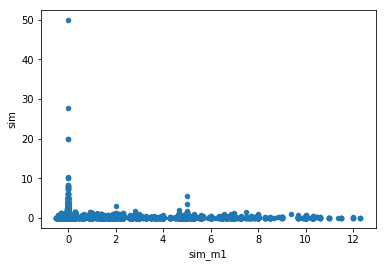

In [77]:
df_temp.plot(kind="scatter", x="sim_m1", y="sim")

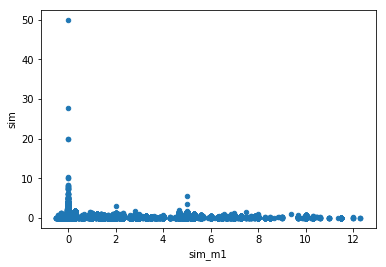

In [29]:
df.plot(kind="scatter", x="sim_m1", y="sim")

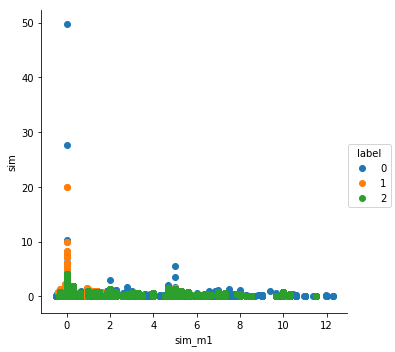

In [30]:
sns.FacetGrid(df, hue="label", size=5) \
   .map(plt.scatter, "sim_m1", "sim") \
   .add_legend()

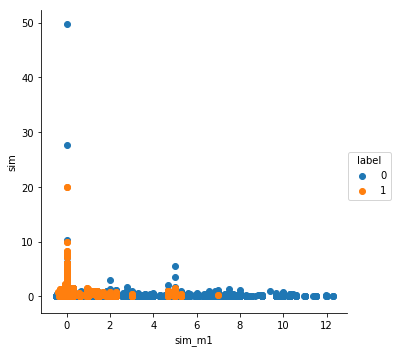

In [78]:
sns.FacetGrid(df_temp, hue="label", size=5) \
   .map(plt.scatter, "sim_m1", "sim") \
   .add_legend()

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Fitting Logistic Regression to the Training set
#from sklearn.linear_model import LogisticRegression
#classifier = LogisticRegression(random_state = 1, solver = 'lbfgs', multi_class = 'multinomial')
#classifier.fit(X_train, y_train)

#from sklearn.ensemble import AdaBoostClassifier
#classifier = AdaBoostClassifier(random_state=1)
#classifier.fit(X_train, y_train)
#model.score(x_test,y_test)

#from sklearn.ensemble import GradientBoostingClassifier
#classifier= GradientBoostingClassifier(learning_rate=0.01,random_state=1)
#classifier.fit(X_train, y_train)
#model.score(x_test,y_test)

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

#from sklearn.naive_bayes import GaussianNB
#classifier = GaussianNB()
#classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [41]:
#AdaBoost
cm

array([[35548, 13856,  5345],
       [ 9847, 35420,  1071],
       [ 9394, 11994, 13856]])

In [42]:
#AdaBoost
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.65      0.65      0.65     54749
          1       0.58      0.76      0.66     46338
          2       0.68      0.39      0.50     35244

avg / total       0.63      0.62      0.61    136331



In [32]:
#GNB
cm

array([[ 2441, 46863,  5445],
       [  191, 45961,   186],
       [ 2948, 23040,  9256]])

In [33]:
#GNB
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.44      0.04      0.08     54749
          1       0.40      0.99      0.57     46338
          2       0.62      0.26      0.37     35244

avg / total       0.47      0.42      0.32    136331



In [56]:
#RF
cm

array([[36704, 13638,  4407],
       [10099, 35172,  1067],
       [ 9487, 11559, 14198]])

In [53]:
cm

array([[36729, 13640,  4380],
       [10098, 35176,  1064],
       [ 9501, 11564, 14179]])

In [57]:
#RF
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.65      0.67      0.66     54749
          1       0.58      0.76      0.66     46338
          2       0.72      0.40      0.52     35244

avg / total       0.65      0.63      0.62    136331



In [38]:
#LR
cm

array([[41200, 10142,  3407],
       [15291, 30823,   224],
       [15847, 10522,  8875]])

In [39]:
#LR
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.57      0.75      0.65     54749
          1       0.60      0.67      0.63     46338
          2       0.71      0.25      0.37     35244

avg / total       0.62      0.59      0.57    136331



In [ ]:
#Ensemble Models
from sklearn.model_selection import StratifiedKFold
def Stacking(model,train,y,test,n_fold):
    folds=StratifiedKFold(n_splits=n_fold,random_state=1)
    test_pred=np.empty((test.shape[0],1),float)
    train_pred=np.empty((0,1),float)
    for train_indices,val_indices in folds.split(train,y.values):
        x_train,x_val=train.iloc[train_indices],train.iloc[val_indices]
        y_train,y_val=y.iloc[train_indices],y.iloc[val_indices]
        model.fit(X=x_train,y=y_train)
        train_pred=np.append(train_pred,model.predict(x_val))
        test_pred=np.append(test_pred,model.predict(test))
    return test_pred.reshape(-1,1),train_pred

In [ ]:
model1 = GaussianNB()

test_pred1 ,train_pred1=Stacking(model=model1,n_fold=10, train=X_train,test=X_test,y=y_train)

train_pred1=pd.DataFrame(train_pred1)
test_pred1=pd.DataFrame(test_pred1)

In [ ]:
model2 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)

test_pred2 ,train_pred2=Stacking(model=model2,n_fold=10,train=x_train,test=x_test,y=y_train)

train_pred2=pd.DataFrame(train_pred2)
test_pred2=pd.DataFrame(test_pred2)

In [ ]:
df = pd.concat([train_pred1, train_pred2], axis=1)
df_test = pd.concat([test_pred1, test_pred2], axis=1)

model = LogisticRegression(random_state = 1, solver = 'lbfgs', multi_class = 'multinomial')
model.fit(df,y_train)
model.score(df_test, y_test)

from sklearn.metrics import confusion_matrix
cm_ensemble = confusion_matrix(y_test, y_pred)

In [ ]:
cm

In [ ]:
cm

In [ ]:
LogisticRegression?

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [58]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
s = 0
count1 = 0


sim_test = [0]*len(test_df)


for i in range(len(test_df)):
    #if t1_list_test_str[i] != '' and t2_list_test_str[i] != '' :
        list = ['']*2
        list[0] = t1_list_test_str[i]
        list[1] = t2_list_test_str[i]  
        m = vect.fit_transform(list).toarray()
        sim_test[count1] = sum(np.multiply(m[0],m[1]))/len(m[0])
        #s = s + sum(np.multiply(m[0],m[1]))/len(m[0])
        count1 = count1+1
        
    
        
sim_test = sim_test[:count1]




count1 = 0


sim_test_m1 = [0]*len(test_df)


for i in range(len(test_df)):
    #if t1_list_test_str[i] != '' and t2_list_test_str[i] != '' :
        list1 = [0] * 16
        list2 = [0] *16
        for j in range(len(m_list)):
            if(m_list[j] in t1_list_test_str[i]):
                list1[j] = 1
        for j in range(len(m_list)):
            if(m_list[j] in t2_list_test_str[i]):
                list2[j] = 1
        sim_test_m1[count1] = sum(np.multiply(m1_list,list2)) + sim_test[count1] - sum(np.multiply(m1_list,list1)) /len(m1_list)
        #s = s + sum(np.multiply(m[0],m[1]))/len(m[0])
        count1 = count1+1
            
sim_test_m1 = sim_test_m1[:count1]


In [59]:
count1

80126

In [60]:
len(sim_test_m1)

80126

In [61]:
l1 = len(sim_test_m1)
X_t =[0] * l1
for i in range(l1):
    X_t[i] = [0] *2
    
count1 = 0 

for i in range(len(test_df)):
    #if t1_list_test_str[i] != '' and t2_list_test_str[i] != '' :
        X_t[count1][0] = sim_test[count1] 
        X[count1][1] = sim_test_m1[count1]
        count1 = count1+1
   
  

In [ ]:
count1

In [62]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier.fit(X, y)

# Predicting the Test set results
y_pred_f = classifier.predict(X_t)

In [67]:
len(y_pred_final)

80126

In [66]:
y_pred_final = [0] * len(y_pred_f)
for i in range(len(y_pred_f)):
    if y_pred_f[i] == 0:
        y_pred_final[i] ='unrelated'
    elif y_pred_f[i] == 1:
        y_pred_final[i] = 'agreed'
    elif y_pred_f[i] == 2:
        y_pred_final[i] = 'disagreed' 
        
        
y_pred_sub = [0] * len(y_pred_f)
for i in range(len(y_pred_f)):
    y_pred_sub[i] = [0] * 2

for i in range(len(y_pred_sub)):
    y_pred_sub[i][0] = test_df.iloc[i,0]
    
for i in range(len(y_pred_sub)):
    y_pred_sub[i][1] = y_pred_final[i]

In [68]:
out = pd.DataFrame(y_pred_sub, columns = ["Id", "Category"])
out.to_csv('/Users/Administrator/Downloads/FakeNewsWSDM/outputNov24_OverSampling.csv', index = False)

In [69]:
for i in range(len(y_pred_final)):
    if y_pred_final[i] != 'unrelated' and y_pred_final[i] != 'agreed':
        print(y_pred_final[i])

disagreed
disagreed
disagreed
disagreed
disagreed
disagreed
disagreed
disagreed
disagreed
disagreed
disagreed
disagreed
disagreed
disagreed
disagreed
disagreed


In [ ]:
len(out)

In [ ]:
len(train_df[train_df['label'] == 'disagreed'])

In [ ]:
len(train_df)